# Text Classification for the IMDB Dataset using BERT.

**Objective:** classify the IMDB Reviews into positive or negative. <br>
In this notebook we explore [BERT](https://arxiv.org/abs/1810.04805), a pre-Trained NLP model by google released in 2018. <br> 
We use the [Transfer Learning](https://towardsdatascience.com/transfer-learning-in-nlp-fecc59f546e4) procedure by loading a pre-trained BERT and refining its weights on our own textual dataset. <br>
The dataset can be downloaded from [Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).<br>
This notebook requires a GPU; you can use google colab if your local machine has none. <br>
**Useful documentation:** <br>
[Pytorch Pretrained Model](https://huggingface.co/transformers/v1.0.0/quickstart.html) <br>
[Pytorch DataLoader](https://pytorch.org/docs/stable/data.html) <br>
[BERT Adam Optimiser](https://huggingface.co/transformers/v1.0.0/migration.html)<br>
[Pytorch BERT For Sequence Classification](https://huggingface.co/transformers/v3.0.2/model_doc/bert.html) <br>

# Installation of needed libraries

In [3]:
from google.colab import files
uploaded = files.upload()


Saving IMDB Dataset.csv to IMDB Dataset.csv


In [ ]:
# !pip install numpy==1.19.5
# !pip install tensorflow==1.14.0
# !pip install torch==1.9.0
# !pip install scikit-learn==0.21.3
# !pip install pytorch_pretrained_bert==0.6.2 pytorch-nlp==0.5.0     
# !pip install tqdm==4.41.1
# !pip install pandas==1.1.5
# !pip install matplotlib==3.2.2
# !pip install beautifulsoup4==4.6.3

# Importing needed libraries

In [5]:
!pip install pytorch_pretrained_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.5 MB/s eta 0:00:00


In [6]:
import warnings
warnings.filterwarnings("ignore") 
import os
import numpy as np
import pickle
import tensorflow as tf



# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [7]:
df = pd.read_csv("IMDB Dataset.csv",engine='python', error_bad_lines=False)

# Exploratory Data Analysis (EDA)

In [8]:
df.isnull().sum(), set(df.sentiment)

(review       0
 sentiment    0
 dtype: int64,
 {'negative', 'positive'})

In [9]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
from sklearn.preprocessing import LabelEncoder

#sentiment is positive and negative we need to convert it to 0,1
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])

In [11]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [12]:
df['sentiment']

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [13]:
#cleaning the text
from bs4 import BeautifulSoup
import re

def strip(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub('\[[^]]*\]', '', soup.get_text())
    pattern=r"[^a-zA-Z\s]"#r"[^a-zA-Z0-9\s,']"
    text=re.sub(pattern,'',text)
    return text

df['review']=df['review'].apply(strip)

### Understanding this function

- The function uses the BeautifulSoup library to parse the text and remove any HTML tags present in it. This is done using the soup.get_text() method.
- It removes any characters that are enclosed in square brackets using regex - and is removing special annotations, references or citation markers in the text.
- It removes all characters from the text that are not alphabets or whitespaces, using regular expression substitution to remove any punctuation marks, special characters, digits or symbols from the text.

In [14]:
strip('bhdezhhfez1235,,,,ff hbffk')

'bhdezhhfezff hbffk'

In [15]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1


# Adapting our input corpus to BERT's requirements
BERT expects input data in a specific format
1. We are performing a classification task so we use a special token [CLS] to indicate this to BERT.
2. It needs to know the end of a sentence so we use the [SEP] token.

### Understanding special tokens with BERT

BERT expects the input data to be in a specific format that includes special tokens to represent the start and end of sentences as well as any special tokens indicating the task type.

- It first extracts the text reviews from the df DataFrame and assigns them to the sentences variable.
- It then creates a new list sentence that contains the special tokens [CLS] and [SEP] around each of the sentences in sentences. The [CLS] token indicates the start of a sentence and is used by BERT to perform classification tasks. The [SEP] token is used to indicate the end of a sentence and is used by BERT to perform tasks that require sentence-level understanding.
- The resulting list of sentences with the special tokens is then assigned to the sentence variable.


Overall, this code is a common preprocessing step when using BERT for text classification tasks. By adding the [CLS] and [SEP] tokens, we are telling BERT where the sentence starts and ends, as well as the task type, which enables the model to better understand the input data and perform the task accurately.

In [16]:
sentences = df['review']
sentence = ["[CLS] "+i+" [SEP]" for i in sentences]

In [17]:
sentence[0]

'[CLS] One of the other reviewers has mentioned that after watching just  Oz episode youll be hooked They are right as this is exactly what happened with meThe first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the wordIt is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to manyAryans Muslims gangstas Latinos Christians Italians Irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayI would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare Forget pretty p

# Tokenizing text
We need to tokenize our text into tokens that correspond to BERT’s vocabulary --> BertTokenizer

In [18]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:510] , sentence))
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 345494.58B/s]


Tokenize the first sentence:
['[CLS]', 'one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', 'oz', 'episode', 'you', '##ll', 'be', 'hooked', 'they', 'are', 'right', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'met', '##he', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'un', '##fl', '##in', '##ching', 'scenes', 'of', 'violence', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', 'trust', 'me', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'tim', '##id', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', 'sex', 'or', 'violence', 'its', 'is', 'hardcore', 'in', 'the', 'classic', 'use', 'of', 'the', 'word', '##it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'pen', '##ite', '##nta', '##ry', 'it', 'focuses', 'mainly', 'on', 'emerald', 'city', 'an'

# First step of vectorization: converting words into their ids using BERT vcabulary
The id of a token (word) is a sequence of integers which uniquely identify this token to this index number. <br>
Thus we call the method "convert_tokens_to_ids" of the BertTokenizer class.

In [19]:
# Set the maximum sequence length. 
MAX_LEN = 128

# Pad our input tokens so that everything has a uniform length
input_ids = list(map(tokenizer.convert_tokens_to_ids, tokenized_texts))
# or input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Since we are dealing with a classical ML/DL model, input dimension should always be fixed. <br>
As in a traditional ML model, the number of attributes/features/columns should be fixed, in a DL model, the input dimension should be fixed as well. <br>
In our case, the input features are sentences i.e. list of words. In order to make sure that the input has a fixed size, i.e. the sentences having the same size, we will need to fix a max length (MAX_LEN) parameter, which is the maximum number of words composing a sentence. <br>
You might ask yourselves, But every sentence has a different set of words, shouldn't we create an input size that is equal to the number of unique words in our corpus? <br>
The answer is No, because, we will never deal with words, we will deal with embeddings such that all words are embedded with vectors having the same dimension $d$ &rarr; every sentence of our corpus will be transformed into an input of size MAX_LEN $\times d$ &rarr; our input will have the same size. <br>
Thus: <br>
- sentences with number of words > than MAX_LEN will be truncated; we chose a post truncating i.e., the first MAX_LEN are retained and the remaining words are removed. 
- sentences with number of words < than MAX_LEN will be padded; we chose a post padding i.e., the 0 id will be added after the ids of the words present in the sentence.

In [20]:
input_ids = pad_sequences(input_ids,
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Let us look at a sentence with words < MAX_LEN (the sentence max length) and see what the padding does exactly.

In [21]:
for i in range(len(tokenized_texts)):
    if len(tokenized_texts[i])<30:
        print(i)

413
1417
1783
2895
3709
4304
6195
9435
9744
10973
11926
13109
13315
14420
14916
15009
18400
18424
19089
19669
19874
20053
20274
21042
24940
27521
27680
28634
28920
30598
30763
30926
30995
31072
31087
31328
31761
32935
33907
33967
34501
34692
34817
35821
36008
36088
36368
36484
39182
40038
40817
40888
41377
42319
42356
42626
43477
43607
44126
44962
45359
45373
46512
48448
48927


In [22]:
input_ids[413]

array([  101,  1037,  5790,  1997,  2515,  2025,  4088,  2000,  4671,
        2129, 10634,  2139, 24128,  1998, 21660,  2135,  2919,  2023,
        3185,  2003,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [23]:
print("length of sentence 0:", len(tokenized_texts[413]))
print("\nthe first 20 words of the sentence are:")
print(tokenized_texts[413][:20])
print("\nthe first 20 words of the sentence represented by their indices are:")
print(input_ids[413][:20]) 
print("\nlength of sentence 0:", len(tokenized_texts[413]), "vs length of sentence 1:", len(input_ids[413]))
print("they are different!!! Hence, padding is needed!")

length of sentence 0: 21

the first 20 words of the sentence are:
['[CLS]', 'a', 'rating', 'of', 'does', 'not', 'begin', 'to', 'express', 'how', 'dull', 'de', '##pressing', 'and', 'relentless', '##ly', 'bad', 'this', 'movie', 'is']

the first 20 words of the sentence represented by their indices are:
[  101  1037  5790  1997  2515  2025  4088  2000  4671  2129 10634  2139
 24128  1998 21660  2135  2919  2023  3185  2003]

length of sentence 0: 21 vs length of sentence 1: 128
they are different!!! Hence, padding is needed!


In [24]:
print("After padding: \n length of sentence 0:", len(input_ids[0]), "vs length of sentence 1:", len(input_ids[1]))
print("Now all sentences have equal lengths, such that this length is the MAX_LEN variable defined by us:", MAX_LEN)

After padding: 
 length of sentence 0: 128 vs length of sentence 1: 128
Now all sentences have equal lengths, such that this length is the MAX_LEN variable defined by us: 128


# Masked Language Model (MLM)
The first task in pre-training BERT is the MLM. <br>
Words that can be masked are all words that are not padding i.e., words with id!=0

### Understanding MLM:

For each input sequence, the code creates a sequence mask that contains a 1 for each token that is not a padding token and a 0 for each padding token. This mask is then added to the attention_masks list.

The purpose of a masked language model is to predict missing tokens in a sequence, given the context of the surrounding tokens. To do this, the model is trained to predict a randomly masked token in the input sequence, based on the context provided by the other tokens in the sequence. The attention masks are used during training to help the model ignore the padding tokens and focus only on the actual input tokens.

In [25]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# Training
## Split the dataset into train, validation, and test sets
1. Split the data into train (70%), validation (20%), and test (10%). 
2. Convert it to tensors. 
3. Create a data iterator using pytorch DataLoader for each of the sets.
**NB:** The code below should be changed for the split should be done twice, at two stages: <br>
1. split the dataset into train and test
2. split the train into train and validation

In [27]:
from sklearn.utils import shuffle

# Select a batch size for training. 
batch_size = 16
labels = list(df['sentiment'])

# Split the train data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.2)

# Split the train data into train and test sets
train_inputs, test_inputs, train_labels, test_labels, train_masks, test_masks = train_test_split(train_inputs, train_labels, train_masks,
                                                            random_state=2018, test_size=0.1)
train_inputs, train_masks, train_labels = shuffle(train_inputs, train_masks, train_labels, random_state=2018)

In [28]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## Loading pre trained BERT
Since our problem is a classification one, we will load the BERT model that was fine-tuned for a similar classification task. <br>
Pytorch has fine-tuned BERT for several tasks: for BertForMultipleChoice,  BertForSequenceClassification, etc. <br>
In our case, we do a classification, thus we will use BertForSequenceClassification.

In [29]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)#binary classification
if torch.cuda.is_available():
    print(model.cuda())
else:
    print(model)

100%|██████████| 407873900/407873900 [00:34<00:00, 11890730.94B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

# Fine-Tuning BERT with our specific task
The training could take around an hour and a half to run on Colab with a GPU.

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.420579557614194


Epoch:  25%|██▌       | 1/4 [18:56<56:48, 1136.23s/it]

Validation Accuracy: 0.8448
Train loss: 0.30131846887866653


Epoch:  50%|█████     | 2/4 [37:53<37:53, 1136.83s/it]

Validation Accuracy: 0.8645
Train loss: 0.2273644471752147


Epoch:  75%|███████▌  | 3/4 [56:47<18:55, 1135.59s/it]

Validation Accuracy: 0.8664
Train loss: 0.17679375088049307


Epoch: 100%|██████████| 4/4 [1:15:42<00:00, 1135.59s/it]

Validation Accuracy: 0.8719


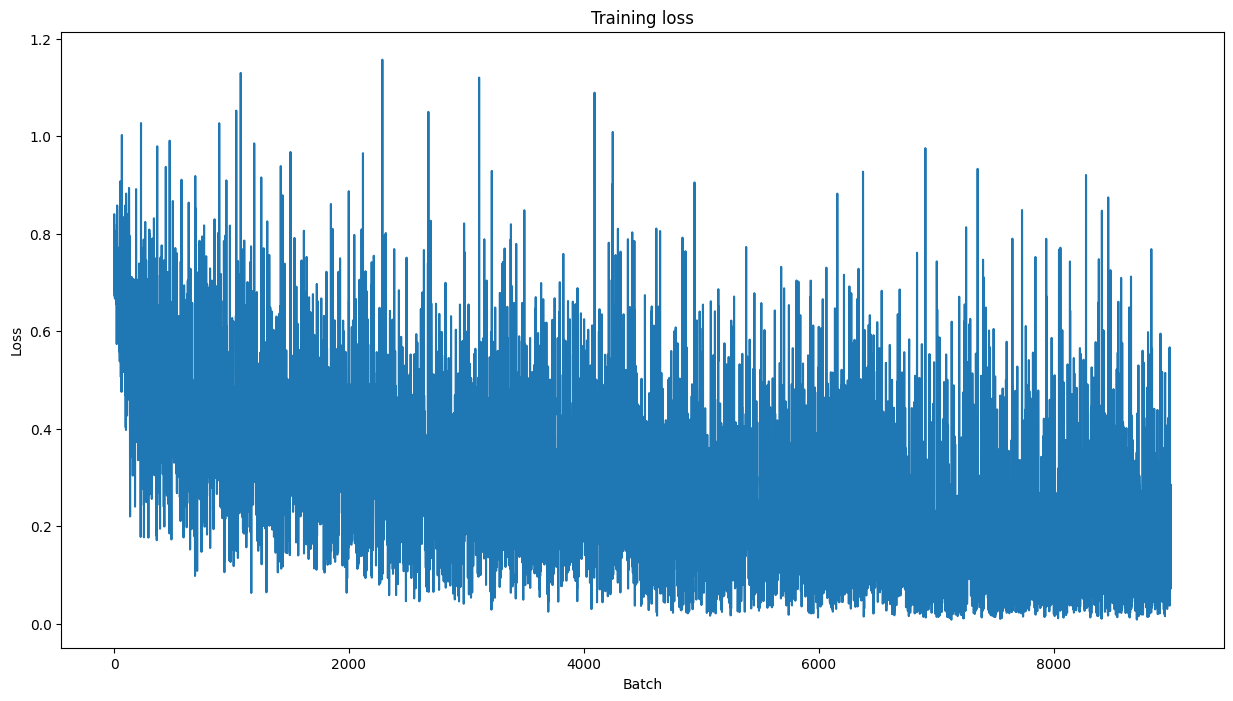

In [30]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(#model.parameters(),#
                     optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() # Returns the indices of the maximum values along an axis.
    labels_flat = labels.flatten()# Converts an N dimensional array to a 1D array
    return np.sum(pred_flat == labels_flat) / len(labels_flat) # accuracy

torch.cuda.empty_cache() 
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
    model.train()  
  # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
      # Forward pass
      #https://huggingface.co/transformers/v3.0.2/model_doc/bert.html
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
      # Backward pass
        loss.backward()
      # Update parameters and take a step using the computed gradient
        optimizer.step()
      # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
    model.eval()
  # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
    for batch in validation_dataloader:
      # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
        # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
      # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

### Understanding the Model


It looks like the model's training loss is decreasing with each epoch, which indicates that the model is learning from the training data. The validation accuracy is also increasing with each epoch, which means that the model is generalizing well to unseen data. 

Overall, the model seems to be performing well, with a validation accuracy of around 87%. However, we know that this performance is only on the training set, and to get a more accurate estimate of its performance, we need to evaluate the model on our test set that was not used during training 

## Test the model on the test set

Test Accuracy: 0.87025


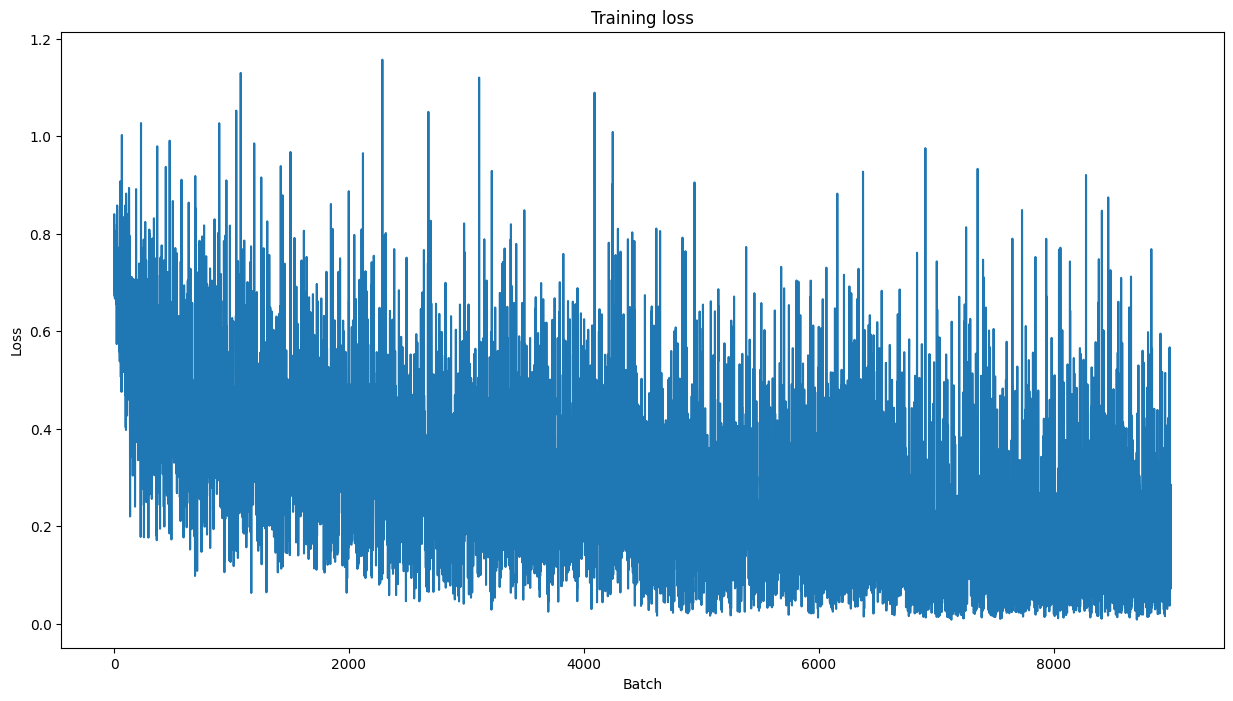

In [32]:
model.eval()
# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
# Evaluate data for one epoch
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
print("Test Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()



An accuracy of 0.87 means that the model correctly predicted 87% of the labels in the test set. In other words, out of all the examples in the test set, the model correctly classified 87% of them. We can also see from the graph that the loss curve is generally decreasing indicating the model generalises well. 

The accuracy metric is often used as a measure of how well a machine learning model is performing, however, it's accuracy may not always be the best choice of evaluation. Therefore, it would be a good idea to look at other evaluation metrics such as precision, recall, and F1-score to get a more comprehensive view of the model's performance.